In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout

%matplotlib inline
tf.__version__

'1.14.0'

In [3]:
# Now let's define the path to our train, validation and test directories
dataset_path = "./Desktop/chest_xray/"

In [5]:
train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

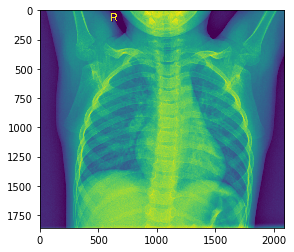

In [6]:
# Let's visualize some an example in the training set
example_img = mpimg.imread(train_dir + "/NORMAL/IM-0115-0001.jpeg")
plt.imshow(example_img)

In [7]:
''''
Mandatory:
dataset: string, dataset from where we extract images
category: string, category within the dataset (NORMAL, PNEUMONIA)

Optional:
labeled: boolean, determine if images should be labeled
sample_size: int, number of images to display
'''
def plot_img(subset, category, labeled = False, sample_size = 6):
  
  full_path = dataset_path + subset + '/' + category
  
  # Check if sample_size is valid
  if (sample_size > len([file for file in os.listdir(full_path)])):
      print(len([file for file in os.listdir('.') if os.path.isfile(file)]))
      print("Not enough files in ", full_path)
      return
    
  # Define the figure size
  plt.figure(figsize=(18, 12))
  
  for i, file in enumerate(os.listdir(full_path)):

    # Check if number of images to display has been reached
    if(i >= sample_size):
      break
    img = mpimg.imread(full_path + '/' + file)
    plt.subplot(231 + i)

    if labeled:
      plt.title(file.split('-')[1])
    
    plt.imshow(img)

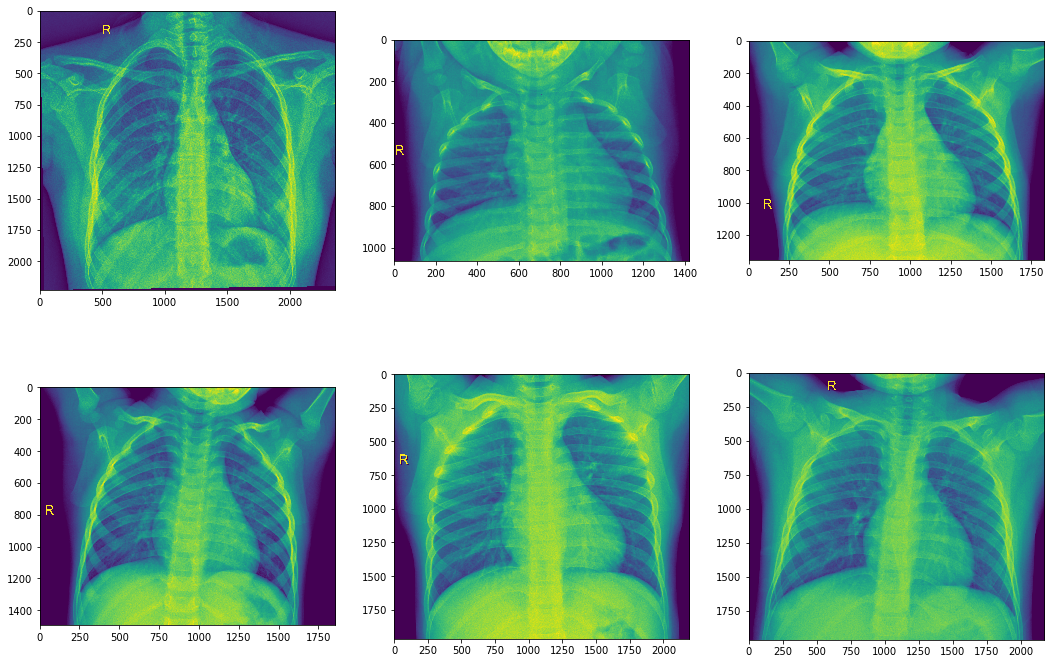

In [8]:
# Calling the above function
plot_img("train", "NORMAL")

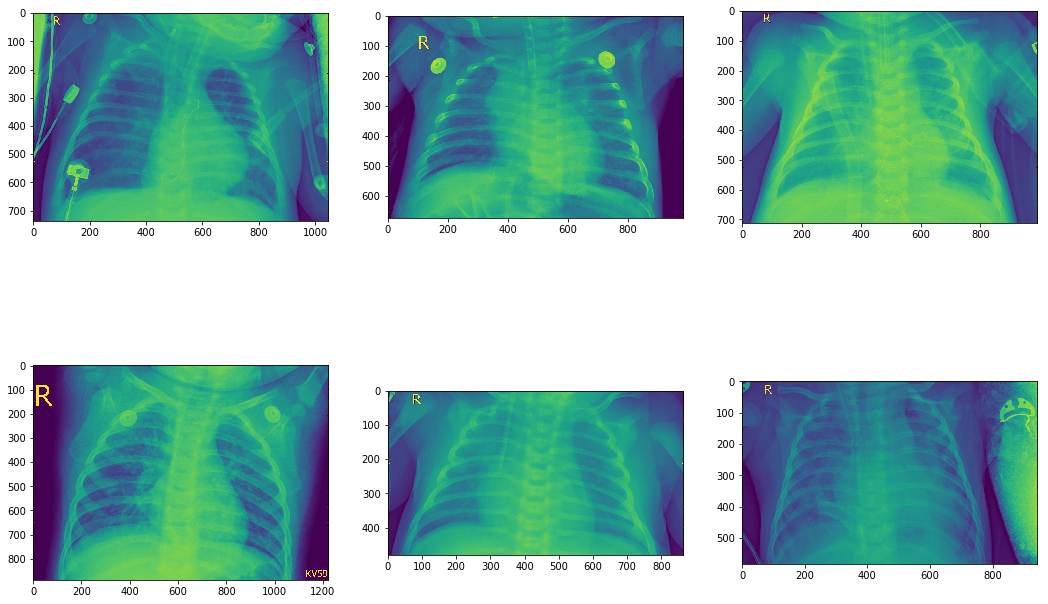

In [9]:
# With pneumonia cases
plot_img("train", "PNEUMONIA")

In [10]:
#Lets make a function that compare those with pneumonia and Normal


def compare_img(subset, labeled = False):
  path = dataset_path + subset
  
  # Taking a random sample from both the PNEUMONIA and the NORMAL directory
  random_pneumonia = np.random.choice(os.listdir(path + "/PNEUMONIA"))
  random_normal = np.random.choice(os.listdir(path + "/NORMAL"))
  
  # Figure size
  fig=plt.figure(figsize=(16, 16))


  # Displaying images
  a = fig.add_subplot(1, 2, 1)
  normal = mpimg.imread(path + "/NORMAL/" + random_normal)
  image1 = plt.imshow(normal)
  
  
  # Option to show the label 
  if labeled:
    a.set_title('NORMAL')
    
  a = fig.add_subplot(1, 2, 2)
  pneumonia = mpimg.imread(path + "/PNEUMONIA/" + random_pneumonia)
  image2 = plt.imshow(pneumonia)
  
    
    # Option to show the label 
  if labeled:
    a.set_title('PNEUMONIA')
  

  plt.show()

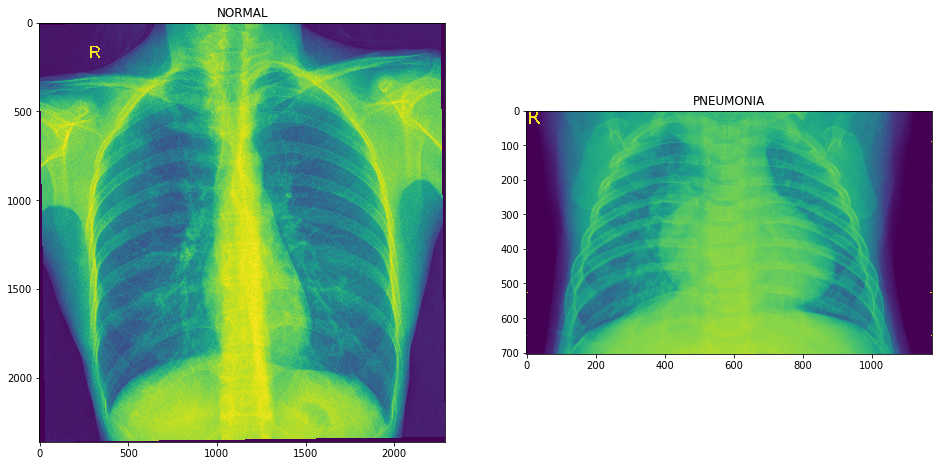

In [11]:
# Let's compare one image showasing pneumonia and one normal
compare_img("train", labeled = True)

# Training tghe Model
Loading the Pretrained model(Inception V3)

In [12]:
img_shape = (150, 150, 3)

In [14]:
base_model = tf.keras.applications.InceptionV3(input_shape = img_shape, include_top = False, weights="imagenet")

W1003 13:21:31.723895 4477007296 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


87916544/87910968 [==============================] - 147s 2us/step


In [15]:
base_model.summary() # This is quite a complex architecture

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [16]:
#freezing the Model
base_model.trainable = False

In [17]:
#Defining a custom header for our Network
base_model.output

<tf.Tensor 'mixed10/concat:0' shape=(?, 3, 3, 2048) dtype=float32>

In [18]:
#Using a pooling layer to reduce the output dimension
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [19]:
global_average_layer

<tf.Tensor 'global_average_pooling2d/Mean:0' shape=(?, 2048) dtype=float32>

In [20]:
global_average_layer = Dense(512, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(256, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(128, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
prediction_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')(global_average_layer)

# Defining The Model

In [21]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Compiling The Model

In [23]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Creating Image Data Generator 
Image Resizing

In [24]:
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

In [25]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 5216 images belonging to 2 classes.


In [26]:
valid_generator = data_gen_valid.flow_from_directory(validation_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 16 images belonging to 2 classes.


In [27]:
test_generator = data_gen_valid.flow_from_directory(test_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 624 images belonging to 2 classes.


# Now, we train the Model
Also, validation data shows overfitting, so we use epochs = 5

In [28]:
model.fit_generator(train_generator, epochs = 5, validation_data = valid_generator)

Epoch 1/5


W1003 13:38:25.259423 4477007296 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


41/41 [==============================] - 189s 5s/step - loss: 0.5058 - acc: 0.7859 - val_loss: 1.4684 - val_acc: 0.5625
Epoch 2/5
41/41 [==============================] - 176s 4s/step - loss: 0.3153 - acc: 0.8754 - val_loss: 2.2486 - val_acc: 0.5000
Epoch 3/5
41/41 [==============================] - 186s 5s/step - loss: 0.2551 - acc: 0.9045 - val_loss: 1.4816 - val_acc: 0.7500
Epoch 4/5
41/41 [==============================] - 199s 5s/step - loss: 0.2364 - acc: 0.9082 - val_loss: 1.6818 - val_acc: 0.6250
Epoch 5/5
41/41 [==============================] - 211s 5s/step - loss: 0.2213 - acc: 0.9160 - val_loss: 1.2807 - val_acc: 0.7500


In [29]:
#Model Evaluation
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)

In [30]:
print("Accuracy after transfer learning: {}".format(valid_accuracy))

Accuracy after transfer learning: 0.75


# Plotting the results
The below function will compare the true values with the predicted ones using the validation which contains only 16 images (8 for both classes)

Note on model prediction:

0 => pneumonia
1 => normal

In [31]:

def compare_results(root_path, generator):

  predictions = model.predict_generator(generator) # Return numpy array of predictions
  class_predicted= [np.argmax(prediction) for prediction in predictions]
  fig = plt.figure(figsize=(24, 18))
  fig.subplots_adjust(hspace=1.5)
  
  normal_path = root_path + '/NORMAL/'
  pneumonia_path = root_path + '/PNEUMONIA/'
  
  normal_dir = os.listdir(normal_path)
  pneumonia_dir = os.listdir(pneumonia_path)
  
  # Generators
  normal_gen =  (x for x in normal_dir if x.endswith('.jpeg'))
  pneumonia_gen =  (y for y in pneumonia_dir if y.endswith('.jpeg'))
  
  for i, normal_file in enumerate(normal_gen):
    img = plt.imread(normal_path + normal_file)
    plt.subplot(4, 4, 1 + i)
    plt.title(f"Prediction: NORMAL\nTrue value: NORMAL" if class_predicted[i] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: NORMAL")
    plt.imshow(img)
    
  for j, pneumonia_file in enumerate(pneumonia_gen):
    img = plt.imread(pneumonia_path + pneumonia_file)
    plt.subplot(4, 4, 9 + j)
    plt.title(f"Prediction: NORMAL\nTrue value: PNEUMONIA" if class_predicted[8+j] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: PNEUMONIA")
    plt.imshow(img)

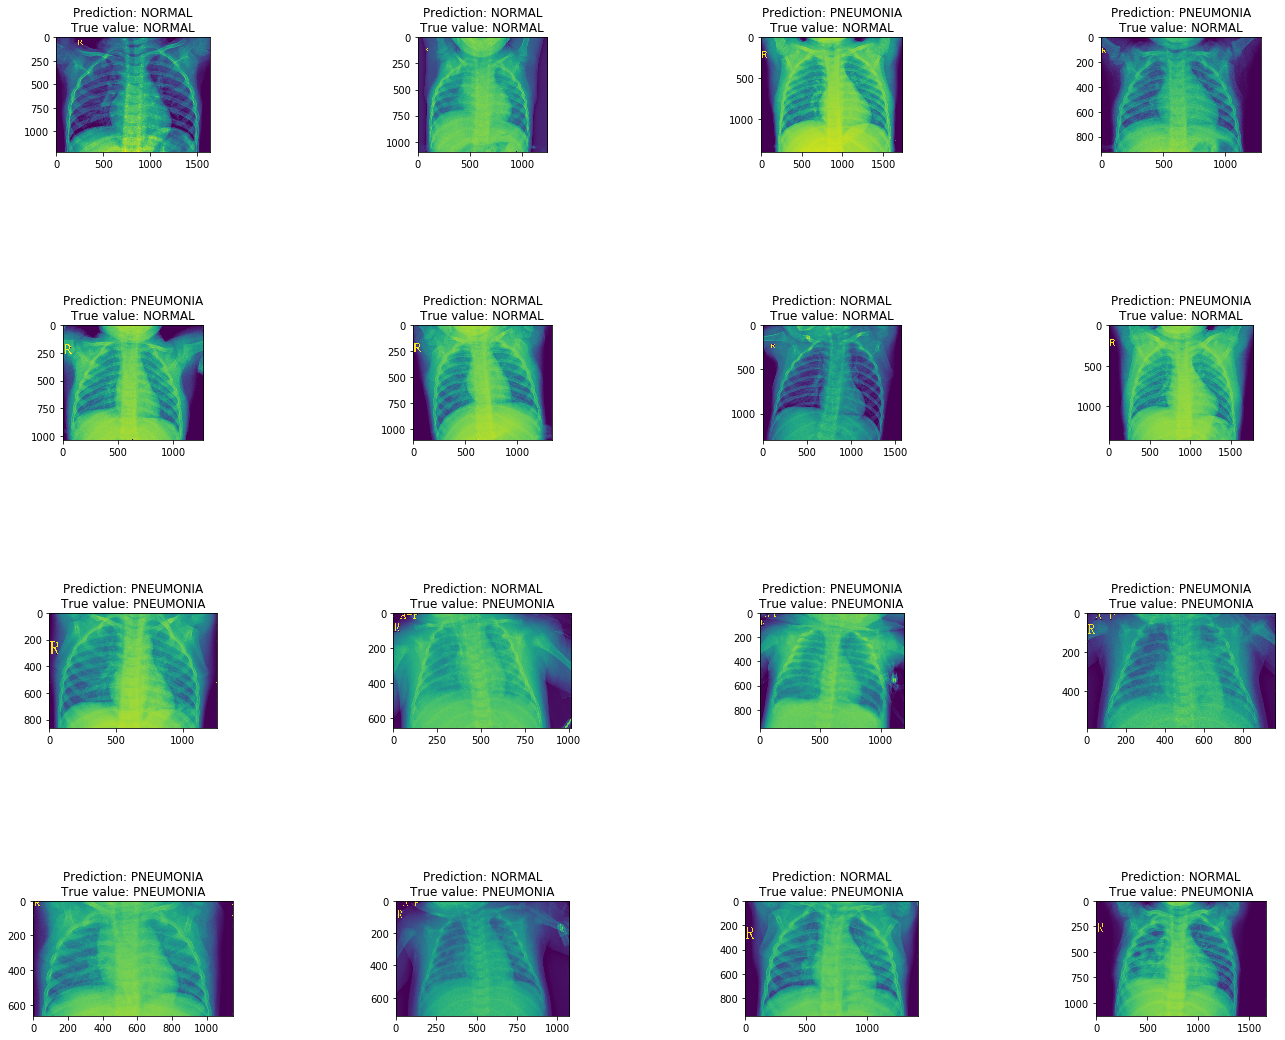

In [32]:
compare_results(validation_dir, valid_generator)

In [33]:
# saving model as a JSON
import json
model_json = model.to_json()
with open("architecture.json", "w") as json_file:
    json_file.write(model_json)

In [34]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
